## BMI-206 Course Project
### Group 3 
#### Members:
- 
- 
-


In [2]:
import pandas as pd
from glob import glob
import os

### GWAS data and analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/2)

#### Fig 4.a. (GWAS Manhattan plot by @IJbeasley)


<img src="figures/t1d_uk_bb.h.filt.fig4a.png" align="center"/>

### Single-cell data and analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/3)

___
R Scripts

In [ ]:
# suppressMessages(suppressWarnings(library('SCENT')))
# suppressMessages(suppressWarnings(library('Seurat')))
# suppressMessages(suppressWarnings(library('SingleCellExperiment')))
# suppressMessages(suppressWarnings(library('tidyverse')))
# suppressMessages(suppressWarnings(library('anndata')))

In [ ]:
# library('Matrix')

In [ ]:
# # Create SingleCellExperiment objects that points to on-disk H5AD file
# rna_h5ad_file = 'data/GSE243917_genesXcells_ALL_raw.h5ad'
# atac_h5ad_file = 'data/GSE243917_peaksXcells_ALL_raw.h5ad'

# rna <- anndata::read_h5ad(rna_h5ad_file)
# atac <- anndata::read_h5ad(atac_h5ad_file)

# # Convert to dgCMatrix using Matrix package
# rna$X <- Matrix(rna$X, "dgCMatrix")
# atac$X <- Matrix(atac$X, "dgCMatrix")

In [ ]:
# SCENT_obj <- SCENT::CreateSCENTObj(
#     rna = rna$X,
#     atac = atac$X,
#     meta.data = rna$obs,
#     peak.info = atac$obs,
#     covariates = c("log(nUMI)","percent.mito","sample", "batch"), 
#     celltypes = "ct" # cell type column
# )

___

In [15]:
res_1 = pd.read_csv('data/zoe-scent-results/500kb_Tcell_allcvar.txt.gz', sep=' ')

In [16]:
res_1

,gene,peak,beta,se,z,p,boot_basic_p
0,TP53BP2,chr1:223831938-223832138,0.332012,0.037937,8.751728,2.101095e-18,0.00004
1,TP53BP2,chr1:223844015-223844215,0.371481,0.052382,7.091813,1.323664e-12,0.00004
2,TP53BP2,chr1:223844854-223845054,-0.075517,0.066909,-1.128651,2.590452e-01,0.52000
3,TP53BP2,chr1:223845439-223845639,-0.104341,0.041429,-2.518541,1.178421e-02,0.06400
4,TP53BP2,chr1:223846024-223846224,0.032122,0.033096,0.970561,3.317668e-01,0.40000
...,...,...,...,...,...,...,...
212331,UBE4B,chr1:9689394-9689594,-0.046080,0.044965,-1.024800,3.054577e-01,0.26000
212332,UBE4B,chr1:9717672-9717872,-0.030496,0.048532,-0.628367,5.297634e-01,0.64000
212333,UBE4B,chr1:9719171-9719371,0.130396,0.084853,1.536725,1.243607e-01,0.22000
212334,UBE4B,chr1:9721845-9722045,-0.075218,0.073692,-1.020716,3.073892e-01,0.38000


___
preprocessed files from the SCENT paper:

In [3]:
files = [
    (os.path.basename(file).replace('_allqced_bootpkg_nopc_allCT.FDR0.10.txt.gz',''), file)
    for file in glob('data/enhancer-gene-links-from-the-paper/*.txt.gz')
]

In [4]:
dfs = dict([
    (name, pd.read_csv(file, sep='\t', header=0))
    for name, file in files
])
for name, df in dfs.items():
    print(name, df.shape)
    df.insert(df.shape[-1], column='source', value=name)
    dfs[name] = df

NEAT (1206, 9)
SHARE (243, 9)
Arthritis-tissue (47527, 9)
Pituitary (3014, 9)
NeurIPS (5135, 9)
Brain (14935, 9)
Dogma (10834, 9)
Pubic-PBMC (16574, 9)


In [5]:
df = pd.concat(dfs.values())

In [6]:
df

,gene,peak,beta,se,z,p,boot_p,fdr,celltype,source
0,ABCB1,chr7-87628077-87628577,0.500706,0.053585,9.344141,9.263862e-21,0.00004,0.004394,CD4T,NEAT
1,ABCB1,chr7-87933922-87934422,0.365729,0.061718,5.925819,3.107441e-09,0.00024,0.020356,CD4T,NEAT
2,ABCC4,chr13-95185812-95186312,0.725145,0.127990,5.665620,1.464936e-08,0.00004,0.004394,CD4T,NEAT
3,ABCG1,chr21-42228010-42228510,0.258218,0.061930,4.169491,3.052810e-05,0.00064,0.044259,CD4T,NEAT
4,ACBD3,chr1-225924103-225924603,0.228162,0.064049,3.562334,3.675717e-04,0.00120,0.070984,CD4T,NEAT
...,...,...,...,...,...,...,...,...,...,...
16569,ZSWIM6,chr5-60943494-60944082,0.119328,0.021409,5.573621,2.494979e-08,0.00112,0.059858,Myeloid,Pubic-PBMC
16570,ZSWIM6,chr5-61341984-61342536,0.182571,0.027120,6.731941,1.674150e-11,0.00012,0.011692,Myeloid,Pubic-PBMC
16571,ZZEF1,chr17-3720012-3720728,0.174540,0.051049,3.419049,6.284035e-04,0.00168,0.076966,Myeloid,Pubic-PBMC
16572,ZZEF1,chr17-3913851-3914611,0.155127,0.043049,3.603474,3.139924e-04,0.00060,0.038451,Myeloid,Pubic-PBMC


/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


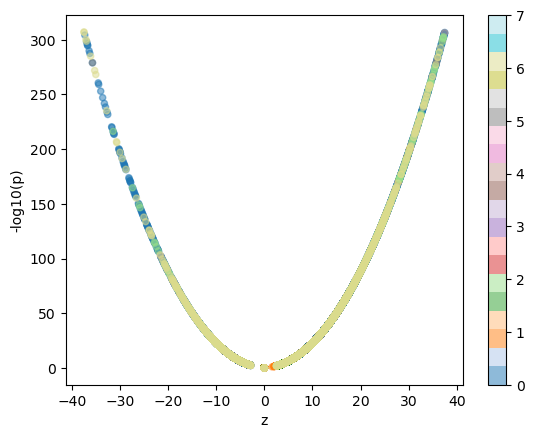

In [ ]:
# draw volcano plot of z vs -log10(p) and color by source
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

df['-log10(p)'] = -np.log10(df['p'])
df.plot.scatter(x='z', y='-log10(p)', alpha=0.5, c=df['source'].astype('category').cat.codes, cmap='tab20')

plt.show()

### Enrichment analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/5)

**Aim:** Causal variant enrichment analysis

**Tasks:**
- [ ] Reimplement enrichment analysis similar to the SCENT paper
- [ ] 

___
> To replicate and expand upon the paper’s disease enrichment analysis of the causal variants identified with SCENT, we will create a set of disease causal variants by filtering the FinnGen fine-mapping results for the most reliable identified fine-mapped traits (e.g., number of case > 1,000) and variants (high purity of casual sets). 

> To evaluate the SCENT’s outcome, Sakaue et al. defined and evaluated causal enrichment for GWAS, eQTLs, caQTL or other ground truth resources such as bulk or single-cell-based enhancer–gene maps (Fig 3, S6-S8). We found this as a useful part of the paper to focus on for more in-depth statistical analysis. We will implement a “causal variant enrichment analysis” formula through custom codes in R or python. As we move forward, we will decide what exact analysis we can perform. We have lots of examples from the sub-figures but we can also go beyond that, for instance we can evaluate what are the effects of changing covariates in the SCENT pipeline.


###

In [15]:
%reload_ext watermark
%watermark
%watermark --iversions

Last updated: 2024-11-19T11:31:04.324646-08:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 4.18.0-477.27.1.el8_8.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

pandas: 2.2.3

